In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/improved/1')
import torch
import torch.nn as nn
from torchvision import datasets
from improved.model import AlexNetImproved, init_params
from improved.pca import pca
from improved.data_transforms import calc_mean_std, prepreprocess, get_preprocess, get_train_augment
from improved.train import train
import matplotlib.pyplot as plt
from improved.eval import top1_k 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', download=True, transform=prepreprocess)
mean, std = calc_mean_std(train_dataset)
preprocess = get_preprocess(mean, std)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
eigvals, eigvecs = pca(train_dataset)
train_augment = get_train_augment(eigvals, eigvecs, mean, std)

train_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=train_augment)

val_dataset = datasets.Imagenette(
    'datasets/imagenette', split='val', size='320px',transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Train: {len(train_dataset)}')
print(f'Validation: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

100%|██████████| 341663724/341663724 [00:06<00:00, 52154032.86it/s]


Extracting datasets/imagenette/imagenette2-320.tgz to datasets/imagenette
Covar:
tensor([[0.9999, 0.9060, 0.7768],
        [0.9060, 0.9999, 0.9098],
        [0.7768, 0.9098, 1.0001]], device='cuda:0')
Eigen values (sqrt):
tensor([[0.2165],
        [0.4725],
        [1.6522]])
Eigen vectors:
tensor([[ 0.4129,  0.7125,  0.5673],
        [-0.8029, -0.0092,  0.5960],
        [ 0.4299, -0.7016,  0.5683]])
Train: 9469
Validation: 1963
Test: 1962


In [4]:
model = AlexNetImproved(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=200,
    initial_lr=0.01,
    num_workers=3,
    patience=20,
)

Epoch 1/200, Cost: 2.051, Val Error: 59.14%, lr: 0.01, Time: 44s
Epoch 2/200, Cost: 1.713, Val Error: 54.25%, lr: 0.01, Time: 44s
Epoch 3/200, Cost: 1.569, Val Error: 37.60%, lr: 0.01, Time: 44s
Epoch 4/200, Cost: 1.397, Val Error: 54.30%, lr: 0.01, Time: 44s
Epoch 5/200, Cost: 1.313, Val Error: 43.50%, lr: 0.01, Time: 43s
Epoch 6/200, Cost: 1.251, Val Error: 35.05%, lr: 0.01, Time: 44s
Epoch 7/200, Cost: 1.170, Val Error: 26.29%, lr: 0.01, Time: 44s
Epoch 8/200, Cost: 1.115, Val Error: 27.41%, lr: 0.01, Time: 43s
Epoch 9/200, Cost: 1.075, Val Error: 33.88%, lr: 0.01, Time: 43s
Epoch 10/200, Cost: 1.019, Val Error: 24.04%, lr: 0.01, Time: 44s
Epoch 11/200, Cost: 0.986, Val Error: 25.47%, lr: 0.01, Time: 43s
Epoch 12/200, Cost: 0.932, Val Error: 24.50%, lr: 0.01, Time: 43s
Epoch 13/200, Cost: 0.916, Val Error: 25.83%, lr: 0.01, Time: 43s
Epoch 14/200, Cost: 0.837, Val Error: 22.77%, lr: 0.01, Time: 43s
Epoch 15/200, Cost: 0.844, Val Error: 24.96%, lr: 0.01, Time: 43s
Epoch 16/200, Cost:

In [6]:
torch.save(model.state_dict(), 'baseline_imagenette.model.pt')
torch.save(preprocess, 'baseline_imagenette.preprocess.pt')
torch.save(train_augment, 'baseline_imagenette.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.Imagenette(
    'datasets/imagenette', split='train', size='320px', transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Train Top 1: {train_top1}')
print(f'Train Top 5: {train_top5}')

Test Top 1: 0.8944954128440367
Test Top 5: 0.9887869520897044
Val Top 1: 0.890983188996434
Val Top 5: 0.9893020886398369
Train Top 1: 1.0
Train Top 5: 1.0


Text(0.5, 1.0, 'Costs')

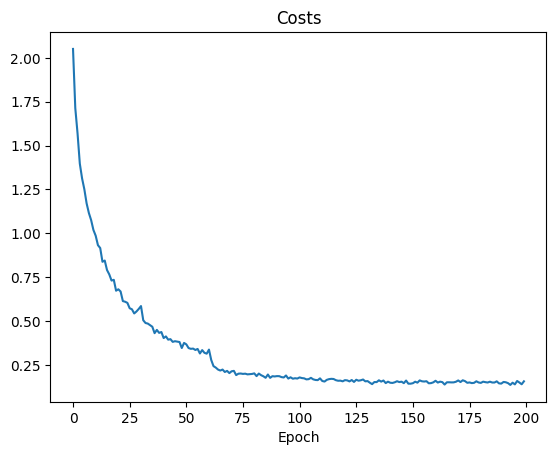

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Cross Validation Error Rates')

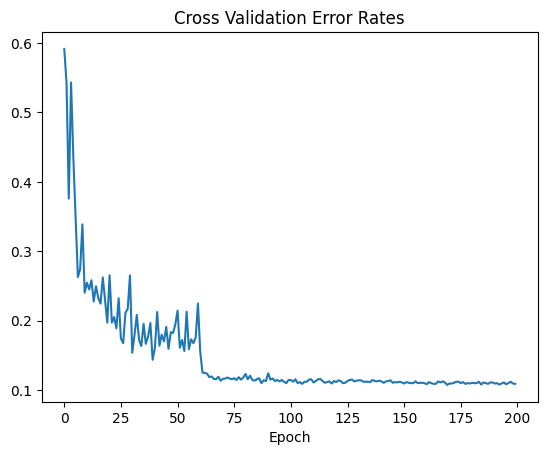

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Cross Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

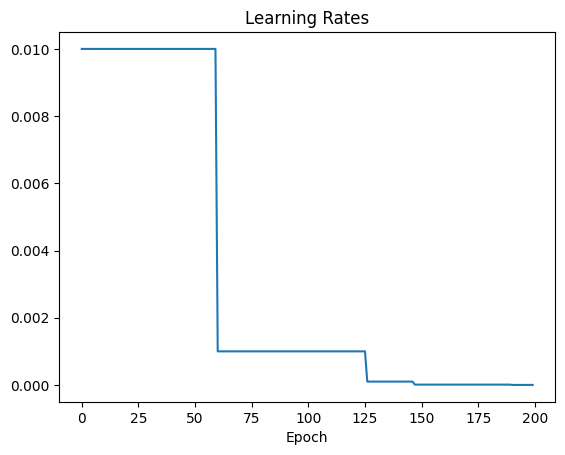

In [10]:
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.title('Learning Rates')